### Example

Lets assume we are the manager of operations for a small company. We operate a few factories that make plumbus-es and ship them to many retailers. Our shipping lanes don't have uniform costs, and due to outside factors some lanes have fixed capacity. For example the route connecting the Garfield plumbus factory to the Woolmart warehouse can only handle at most 36 plumbuses per month and has an average shipping cost per plumbus of $1.69. 

The big boss asks:
**What is the best way to supply our retailers?**

This question, as stated, cannot be confidently answered. Our coworkers in the conference room suggest some solutions:

* "Supply each retailer from the factory with the lowest shipping cost"
* "Supply each retailer first from the factory that has the most supply"
* "Supply Woolmart first because Ted has a friend who works there"
* etc etc

These suggestions certainly sound reasonable, but the problem is that "best" is loosely defined. Should we optimize for transit time, for cost, for distance? For a first model, lets solve the following problem instead:

**What quantity of plumbus-es should we ship from each factory to each warehouse to minimize the total shipping cost?**

and the immediate follow up question, 

**How much will our shipping cost be?**

lets solve it!

#### 1. Load the data
Lets load the data with pandas. It was given to us in excel with three tabs.

In [1]:
import pandas as pd
import numpy as np
import os
file = os.path.join('data','factory_to_warehouse.xlsx')

In [2]:
factories = pd.read_excel(file, sheetname='Factories')
warehouses = pd.read_excel(file, sheetname='Warehouses')
lanes = pd.read_excel(file, sheetname='Lanes')

In [3]:
factories.head(3)

,Factory,Supply
0,Garfield,150
1,Odie,225
2,Pikachu,200


In [4]:
warehouses.head(3)

,Warehouse,Demand
0,SuperStore,50
1,Woolmart,100
2,Starbucklers,50


In [5]:
lanes.head(3)

,origin,destination,cost,capacity
0,Garfield,SuperStore,1.26,122
1,Garfield,Woolmart,1.69,36
2,Garfield,Starbucklers,1.31,29


#### 2. Check that your problem is solvable
While we don't have to check everything. Rather than spend hours trying to debug our program, it helps to spend a few moments and make sure the data you have to work with makes sense. Certainly this doesn't have to be exhaustive, but it saves headaches later.

Some common things to check, specifically in this context:

1. Missing variables
    * Do we have lanes defined for factories or warehouses that don't exist?
2. Impossible conditions
    * Is the total demand more than the total supply?
    * Is the inbound capacity obviously too small to feed each retailer?
    * etc

In [6]:
#Do we have lanes defined for factories or warehouses that don't exist?
all_locations = set(lanes.origin) | set(lanes.destination)

for f in factories.Factory:
    if f not in all_locations:
        print('missing ', f)
        
for w in warehouses.Warehouse:
    if w not in all_locations:
        print('missing ', w)

In [7]:
#Is the total demand more than the total supply?
assert factories.Supply.sum() >= warehouses.Demand.sum()

In [8]:
#Is the inbound capacity obviously too small to feed each retailer?
capacity_in = lanes.groupby('destination').capacity.sum()
check = warehouses.set_index('Warehouse').join(capacity_in)
assert np.all(check.capacity >= check.Demand)

#### 3. Model the data with a graph
Our data has a very obvious graph structure to it. We have factories and warehouses (nodes), and we have lanes that connect them (edges). In many cases the extra effort of explicitly making a graph allows us to have very natural looking constraint and objective formulations. This is absolutely not required but makes reasoning very straightforward. To make a graph, we will use networkx

In [9]:
import networkx as nx

In [10]:
G = nx.DiGraph()

In [11]:
#add all the nodes
for i, row in factories.iterrows():
    G.add_node(row.Factory, supply=row.Supply, node_type='factory')
    
for i, row in warehouses.iterrows():
    G.add_node(row.Warehouse, demand=row.Demand, node_type='warehouse')

In [12]:
#add the lanes (edges)
for i, row in lanes.iterrows():
    G.add_edge(row.origin, row.destination, cost=row.cost, capacity=row.capacity)

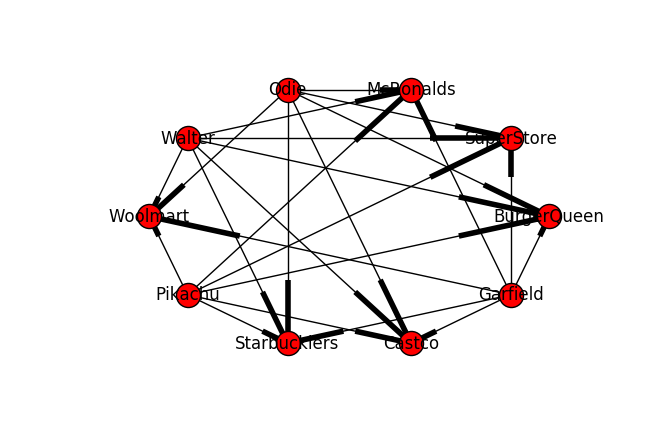

In [13]:
#lets make a quick rendering to spot check the connections
%matplotlib inline
layout = nx.layout.circular_layout(G)
nx.draw(G,layout)
nx.draw_networkx_labels(G,layout);

#### 4. Define the actual Linear Program
So far everything we have done hasn't concerned itself with solving a linear program. We have one primary question to answer here:

**What quantity of plumbus-es should we ship from each factory to each warehouse to minimize the total shipping cost?**

Taking this apart, we are looking for quantities from each factory to each warehouse - these are our shipping lanes. We will need as many variables as we have lanes.

In [14]:
from pulp import *

The variables are the amounts to put on each edge. ```LpVariable.dicts``` allows us to access the variables using dictionary access syntax, i.e., the quantity from Garfield to BurgerQueen is
```python
qty[('Garfield','BurgerQueen')]
```
the actual variable name created under the hood is 
```
qty_('Garfield',_'BurgerQueen')
```

In [15]:
qty = LpVariable.dicts("qty", G.edges(), lowBound=0)

okay cool, so what about our objective? Revisiting the question:

**What quantity of plumbus-es should we ship from each factory to each warehouse to minimize the total shipping cost?**

We are seeking to minimize the shipping cost. So we need to calculate our shipping cost as a function of our variables (the lanes), and it needs to be linear. This is just the lane quantity multiplied by the lane cost.

$$f(Lanes) = \sum_{o,d \in Lanes} qty_{o,d}*cost_{o,d} $$

When dealing with sums in pulp, it is most efficient to use its supplied lpSum function.

In [16]:
#the total cost of this routing is the cost per unit * the qty sent on each lane
def objective():
    shipping_cost = lpSum([ qty[(org,dest)]*data['cost'] for (org,dest,data) in G.edges(data=True)])
    return shipping_cost

We have a few constraints to define:

1. The demand at each retailer must be satisfied. In graph syntax this means the sum of all inbound edges must match the demand we have on file: $$\sum_{o,d \in in\_edges(d)} qty_{o,d} = Demand(d)$$

2. We must not use more supply than each factory has. i.e., the sum of the outbound edges from a factory must be less than or equal to the supply: $$\sum_{o,d \in out\_edges(o)} qty_{o,d} \leq Supply(o)$$

3. Each qty must be less than or equal to the lane capacity: $$qty_{o,d} \leq Capacity_{o,d}$$


networkx makes this very easy to program because we can simply ask for all the inbound edges to a given node using ```nx.Digraph.in_edges```
    

In [17]:
def constraints():
    
    constraints=[]
    
    for x, data in G.nodes(data=True):
        #demand must be met
        if data['node_type'] =='warehouse':
            inbound_qty = lpSum([ qty[(org,x)] for org, _ in G.in_edges(x)])
            c = inbound_qty == data['demand']
            constraints.append(c)
        #must not use more than the available supply
        elif data['node_type'] =='factory':
            out_qty = lpSum([ qty[(x,dest)] for _,dest in G.out_edges(x)])
            c = out_qty <= data['supply']
            constraints.append(c)
            
    #now the edge constraints
    #we qty <= capacity on each lane
    for org,dest, data in G.edges(data=True):
        c = qty[(org,dest)] <= data['capacity']
        constraints.append(c)
        
    return constraints

Finally ready to create the problem, add the objective, and add the constraints

In [18]:
#setup the problem
prob = LpProblem('warehouse_routing',LpMinimize)

In [19]:
#add the objective
prob += objective()

In [20]:
#add all the constraints
for c in constraints():
    prob+=c

Solve it!

In [21]:
%time prob.solve()
print(LpStatus[prob.status])

CPU times: user 3.07 ms, sys: 5.37 ms, total: 8.44 ms
Wall time: 89.2 ms
Optimal


Now we can finally answer:

**What quantity of plumbus-es should we ship from each factory to each warehouse?**

In [22]:
#you can also use the value() function instead of .varValue
for org,dest in G.edges():
    v= value(qty[(org,dest)])
    if v >0:
        print(org,dest, v)

Odie BurgerQueen 30.0
Odie Starbucklers 50.0
Odie Castco 47.0
Odie Woolmart 38.0
Walter Castco 26.0
Pikachu BurgerQueen 40.0
Pikachu McRonalds 57.0
Pikachu Woolmart 62.0
Garfield BurgerQueen 5.0
Garfield SuperStore 50.0
Garfield McRonalds 43.0
Garfield Castco 52.0


and,

**How much will our shipping cost be?**

In [23]:
value(prob.objective)

799.9499999999999

It is a good idea to verify explicitly that all the constraints were met. Sometimes it is easy to forget a necessary constraint.

In [24]:
#lets verify all the conditions
#first lets stuff our result into a dataframe for export
result=[]
for org,dest in G.edges():
    v= value(qty[(org,dest)])
    result.append({'origin':org,'destination':dest,'qty':v})
result_df = pd.DataFrame(result)

In [25]:
lanes['key']=lanes.origin+lanes.destination
result_df['key'] = result_df.origin+result_df.destination

In [26]:
lanes = lanes.set_index('key').merge(result_df.set_index('key'))

In [27]:
#any lane over capacity?
assert np.all(lanes.qty <= lanes.capacity)

In [28]:
#check that we met the demand
out_qty =lanes.groupby('destination').qty.sum()
check = warehouses.set_index('Warehouse').join(out_qty)
assert np.all(check.qty == check.Demand)

In [29]:
#check that we met the supply
in_qty =lanes.groupby('origin').qty.sum()
check = factories.set_index('Factory').join(in_qty)
assert np.all(check.qty <= check.Supply)

In [30]:
#the result!
lanes[lanes.qty !=0]

,origin,destination,cost,capacity,qty
0,Garfield,SuperStore,1.26,122,50.0
3,Garfield,Castco,1.64,78,52.0
4,Garfield,McRonalds,1.41,72,43.0
5,Garfield,BurgerQueen,1.78,86,5.0
7,Odie,Woolmart,1.41,91,38.0
8,Odie,Starbucklers,1.34,77,50.0
9,Odie,Castco,1.91,47,47.0
11,Odie,BurgerQueen,1.75,30,30.0
13,Pikachu,Woolmart,1.36,62,62.0
16,Pikachu,McRonalds,1.71,57,57.0
